In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque, namedtuple
import random
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

try:
    import gymnasium as gym
except ImportError:
    import gym

print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

PyTorch version: 2.9.0+cu126
GPU available: False


# Reinforcement Learning - Train an Agent

## What is Reinforcement Learning?
An agent learns by interacting with an environment:
- Takes actions
- Gets rewards (positive or negative)
- Learns which actions lead to better rewards

## Methods We'll Implement

### 1. Q-Learning (Tabular)
- Maintains a Q-table: Q(state, action)
- Updates based on: Q(s,a) ← Q(s,a) + α[r + γ max Q(s',a') - Q(s,a)]
- Works for discrete state spaces

### 2. Deep Q-Network (DQN)
- Neural network approximates Q-values
- Handles continuous state spaces
- Uses experience replay and target networks

## Environments
- **CartPole**: Balance a pole on a moving cart
- **MountainCar**: Drive a car up a hill (harder)

## Key Concepts
- **State**: Current situation
- **Action**: What agent can do
- **Reward**: Feedback from environment
- **Policy**: Agent's strategy
- **Epsilon-greedy**: Exploration vs exploitation

In [2]:
class EnvironmentManager:

    @staticmethod
    def create_env(env_name='CartPole-v1'):
        try:
            env = gym.make(env_name)
        except:
            env = gym.make(env_name)
        print(f"\nEnvironment: {env_name}")
        print(f"State space: {env.observation_space}")
        print(f"Action space: {env.action_space}")
        return env

    @staticmethod
    def test_environment(env, n_episodes=3):
        print(f"\nTesting random agent for {n_episodes} episodes...")

        for episode in range(n_episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]

            total_reward = 0
            steps = 0
            done = False

            while not done and steps < 200:
                action = env.action_space.sample()
                result = env.step(action)

                if len(result) == 5:
                    next_state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                else:
                    next_state, reward, done, info = result

                total_reward += reward
                steps += 1

            print(f"Episode {episode + 1}: Steps = {steps}, Total Reward = {total_reward}")

cartpole_env = EnvironmentManager.create_env('CartPole-v1')
EnvironmentManager.test_environment(cartpole_env)


Environment: CartPole-v1
State space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)

Testing random agent for 3 episodes...
Episode 1: Steps = 30, Total Reward = 30.0
Episode 2: Steps = 19, Total Reward = 19.0
Episode 3: Steps = 18, Total Reward = 18.0


In [3]:
class QLearningAgent:

    def __init__(self, state_bins, n_actions, learning_rate=0.1, gamma=0.99,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_bins = state_bins
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.q_table = np.zeros(state_bins + (n_actions,))
        print(f"Q-table shape: {self.q_table.shape}")

    def discretize_state(self, state, env):
        """Convert continuous state to discrete bins"""
        state_bounds = list(zip(env.observation_space.low, env.observation_space.high))

        state_bounds = [
            (-4.8, 4.8) if np.isinf(bound[0]) or np.isinf(bound[1]) else bound
            for bound in state_bounds
        ]

        discrete_state = []
        for i, s in enumerate(state):
            bins = np.linspace(state_bounds[i][0], state_bounds[i][1], self.state_bins[i])
            discrete_state.append(np.digitize(s, bins) - 1)
            discrete_state[i] = np.clip(discrete_state[i], 0, self.state_bins[i] - 1)

        return tuple(discrete_state)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        current_q = self.q_table[state][action]

        if done:
            target_q = reward
        else:
            target_q = reward + self.gamma * np.max(self.q_table[next_state])

        self.q_table[state][action] += self.lr * (target_q - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [4]:
class DQN(nn.Module):

    def __init__(self, state_size, action_size, hidden_sizes=[128, 128]):
        super(DQN, self).__init__()

        layers = []
        input_size = state_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size

        layers.append(nn.Linear(input_size, action_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class ReplayBuffer:

    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple('Experience',
                                     ['state', 'action', 'reward', 'next_state', 'done'])

    def push(self, state, action, reward, next_state, done):
        self.buffer.append(self.experience(state, action, reward, next_state, done))

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)

        states = torch.FloatTensor([e.state for e in experiences])
        actions = torch.LongTensor([e.action for e in experiences])
        rewards = torch.FloatTensor([e.reward for e in experiences])
        next_states = torch.FloatTensor([e.next_state for e in experiences])
        dones = torch.FloatTensor([e.done for e in experiences])

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


class DQNAgent:

    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 buffer_size=10000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.policy_net = DQN(state_size, action_size).to(self.device)
        self.target_net = DQN(state_size, action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

        print(f"DQN Agent initialized on {self.device}")
        print(f"Network architecture:\n{self.policy_net}")

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state_tensor)
            return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [5]:
class Trainer:

    @staticmethod
    def train_q_learning(env, agent, n_episodes=500, max_steps=200):
        rewards_history = []
        epsilon_history = []

        print("\nTraining Q-Learning Agent...")

        for episode in range(n_episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]

            discrete_state = agent.discretize_state(state, env)
            total_reward = 0

            for step in range(max_steps):
                action = agent.choose_action(discrete_state)
                result = env.step(action)

                if len(result) == 5:
                    next_state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                else:
                    next_state, reward, done, info = result

                next_discrete_state = agent.discretize_state(next_state, env)

                agent.learn(discrete_state, action, reward, next_discrete_state, done)

                discrete_state = next_discrete_state
                total_reward += reward

                if done:
                    break

            agent.decay_epsilon()
            rewards_history.append(total_reward)
            epsilon_history.append(agent.epsilon)

            if (episode + 1) % 50 == 0:
                avg_reward = np.mean(rewards_history[-50:])
                print(f"Episode {episode + 1}/{n_episodes} | Avg Reward: {avg_reward:.2f} | Epsilon: {agent.epsilon:.3f}")

        return rewards_history, epsilon_history

    @staticmethod
    def train_dqn(env, agent, n_episodes=500, max_steps=500, target_update_freq=10):
        rewards_history = []
        losses_history = []
        epsilon_history = []

        print("\nTraining DQN Agent...")

        for episode in range(n_episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]

            total_reward = 0
            episode_losses = []

            for step in range(max_steps):
                action = agent.choose_action(state)
                result = env.step(action)

                if len(result) == 5:
                    next_state, reward, terminated, truncated, info = result
                    done = terminated or truncated
                else:
                    next_state, reward, done, info = result

                agent.store_experience(state, action, reward, next_state, done)

                loss = agent.learn()
                if loss is not None:
                    episode_losses.append(loss)

                state = next_state
                total_reward += reward

                if done:
                    break

            if (episode + 1) % target_update_freq == 0:
                agent.update_target_network()

            agent.decay_epsilon()

            rewards_history.append(total_reward)
            losses_history.append(np.mean(episode_losses) if episode_losses else 0)
            epsilon_history.append(agent.epsilon)

            if (episode + 1) % 50 == 0:
                avg_reward = np.mean(rewards_history[-50:])
                avg_loss = np.mean(losses_history[-50:])
                print(f"Episode {episode + 1}/{n_episodes} | Avg Reward: {avg_reward:.2f} | Avg Loss: {avg_loss:.4f} | Epsilon: {agent.epsilon:.3f}")

        return rewards_history, losses_history, epsilon_history


In [6]:
print("\n" + "="*50)
print("Q-LEARNING - CARTPOLE")
print("="*50)

env = gym.make('CartPole-v1')
state_bins = (6, 6, 12, 12)
n_actions = env.action_space.n

q_agent = QLearningAgent(
    state_bins=state_bins,
    n_actions=n_actions,
    learning_rate=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.995
)

q_rewards, q_epsilons = Trainer.train_q_learning(env, q_agent, n_episodes=500)

env.close()


Q-LEARNING - CARTPOLE
Q-table shape: (6, 6, 12, 12, 2)

Training Q-Learning Agent...
Episode 50/500 | Avg Reward: 25.48 | Epsilon: 0.778
Episode 100/500 | Avg Reward: 24.30 | Epsilon: 0.606
Episode 150/500 | Avg Reward: 27.68 | Epsilon: 0.471
Episode 200/500 | Avg Reward: 30.38 | Epsilon: 0.367
Episode 250/500 | Avg Reward: 56.80 | Epsilon: 0.286
Episode 300/500 | Avg Reward: 62.90 | Epsilon: 0.222
Episode 350/500 | Avg Reward: 79.60 | Epsilon: 0.173
Episode 400/500 | Avg Reward: 84.54 | Epsilon: 0.135
Episode 450/500 | Avg Reward: 87.62 | Epsilon: 0.105
Episode 500/500 | Avg Reward: 109.16 | Epsilon: 0.082


In [7]:
print("\n" + "="*50)
print("DEEP Q-NETWORK - CARTPOLE")
print("="*50)

env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_agent = DQNAgent(
    state_size=state_size,
    action_size=action_size,
    learning_rate=0.001,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.995
)

dqn_rewards, dqn_losses, dqn_epsilons = Trainer.train_dqn(
    env, dqn_agent, n_episodes=500, target_update_freq=10
)

env.close()


DEEP Q-NETWORK - CARTPOLE
DQN Agent initialized on cpu
Network architecture:
DQN(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

Training DQN Agent...
Episode 50/500 | Avg Reward: 23.30 | Avg Loss: 0.1163 | Epsilon: 0.778
Episode 100/500 | Avg Reward: 45.88 | Avg Loss: 0.2232 | Epsilon: 0.606
Episode 150/500 | Avg Reward: 55.72 | Avg Loss: 0.4173 | Epsilon: 0.471
Episode 200/500 | Avg Reward: 90.12 | Avg Loss: 0.9709 | Epsilon: 0.367
Episode 250/500 | Avg Reward: 80.78 | Avg Loss: 1.1164 | Epsilon: 0.286
Episode 300/500 | Avg Reward: 111.66 | Avg Loss: 1.2192 | Epsilon: 0.222
Episode 350/500 | Avg Reward: 131.60 | Avg Loss: 1.0267 | Epsilon: 0.173
Episode 400/500 | Avg Reward: 192.88 | Avg Loss: 1.0892 | Epsilon: 0.135
Episode 450/500 | Avg Reward: 164.56 | Avg Loss: 1.8362 | Epsilon: 0.10

In [8]:
class Visualizer:

    @staticmethod
    def plot_training_progress(rewards, title, epsilon=None, losses=None):
        if losses is not None:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        else:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            axes = list(axes) + [None]

        window = 50
        rolling_mean = np.convolve(rewards, np.ones(window)/window, mode='valid')

        axes[0].plot(rewards, alpha=0.3, color='blue', label='Episode Reward')
        axes[0].plot(range(window-1, len(rewards)), rolling_mean,
                    color='red', linewidth=2, label=f'{window}-Episode Average')
        axes[0].axhline(y=195, color='green', linestyle='--', label='Target (195)')
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Total Reward')
        axes[0].set_title(f'{title} - Training Rewards')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        if epsilon is not None:
            axes[1].plot(epsilon, color='purple', linewidth=2)
            axes[1].set_xlabel('Episode')
            axes[1].set_ylabel('Epsilon')
            axes[1].set_title('Exploration Rate (Epsilon) Decay')
            axes[1].grid(True, alpha=0.3)

        if losses is not None:
            axes[2].plot(losses, alpha=0.5, color='orange')
            axes[2].set_xlabel('Episode')
            axes[2].set_ylabel('Loss')
            axes[2].set_title('Training Loss')
            axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_comparison(q_rewards, dqn_rewards):
        plt.figure(figsize=(14, 6))

        window = 50
        q_rolling = np.convolve(q_rewards, np.ones(window)/window, mode='valid')
        dqn_rolling = np.convolve(dqn_rewards, np.ones(window)/window, mode='valid')

        plt.plot(range(window-1, len(q_rewards)), q_rolling,
                label='Q-Learning', linewidth=2, color='blue')
        plt.plot(range(window-1, len(dqn_rewards)), dqn_rolling,
                label='DQN', linewidth=2, color='red')
        plt.axhline(y=195, color='green', linestyle='--', label='Target (195)')

        plt.xlabel('Episode')
        plt.ylabel('Average Reward (50 episodes)')
        plt.title('Q-Learning vs DQN Performance Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_statistics(rewards, title):
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        axes[0].hist(rewards, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        axes[0].axvline(np.mean(rewards), color='red', linestyle='--',
                       linewidth=2, label=f'Mean: {np.mean(rewards):.2f}')
        axes[0].set_xlabel('Episode Reward')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title(f'{title} - Reward Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        axes[1].boxplot(rewards)
        axes[1].set_ylabel('Episode Reward')
        axes[1].set_title(f'{title} - Reward Statistics')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"\n{title} Statistics:")
        print(f"Mean: {np.mean(rewards):.2f}")
        print(f"Std: {np.std(rewards):.2f}")
        print(f"Min: {np.min(rewards):.2f}")
        print(f"Max: {np.max(rewards):.2f}")
        print(f"Final 100 episodes average: {np.mean(rewards[-100:]):.2f}")



Q-LEARNING RESULTS


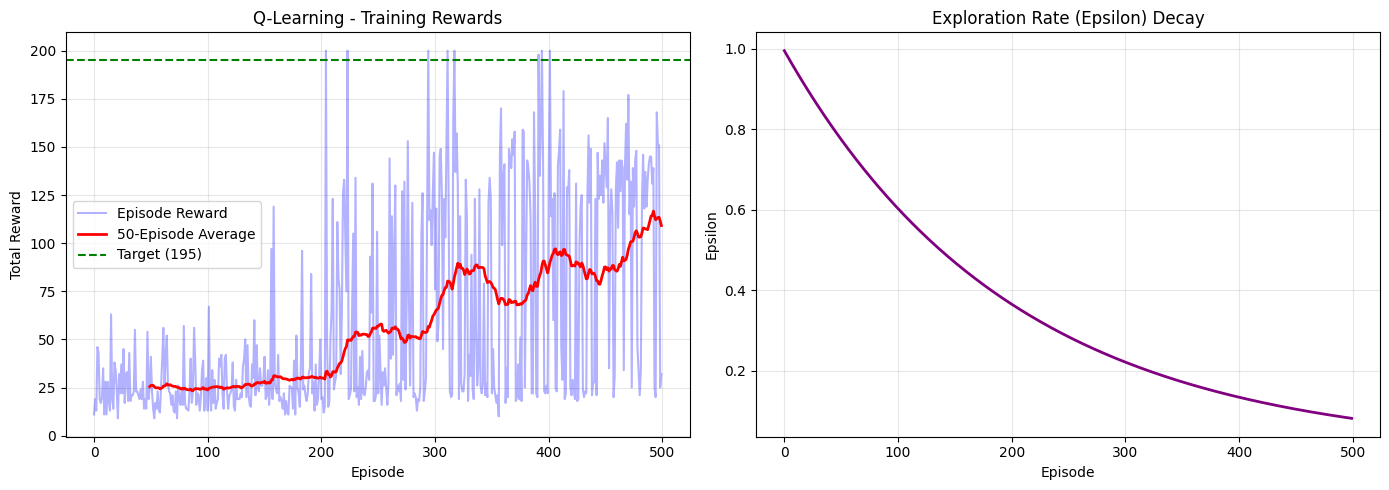

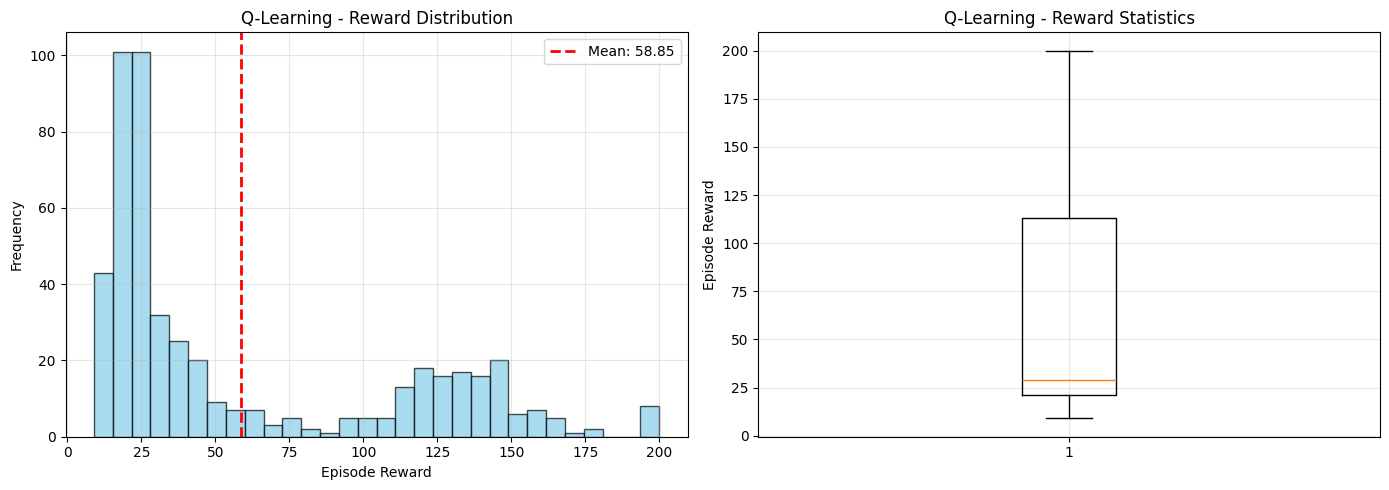


Q-Learning Statistics:
Mean: 58.85
Std: 51.99
Min: 9.00
Max: 200.00
Final 100 episodes average: 98.39


In [9]:
print("\n" + "="*50)
print("Q-LEARNING RESULTS")
print("="*50)

Visualizer.plot_training_progress(q_rewards, "Q-Learning", epsilon=q_epsilons)
Visualizer.plot_statistics(q_rewards, "Q-Learning")


DQN RESULTS


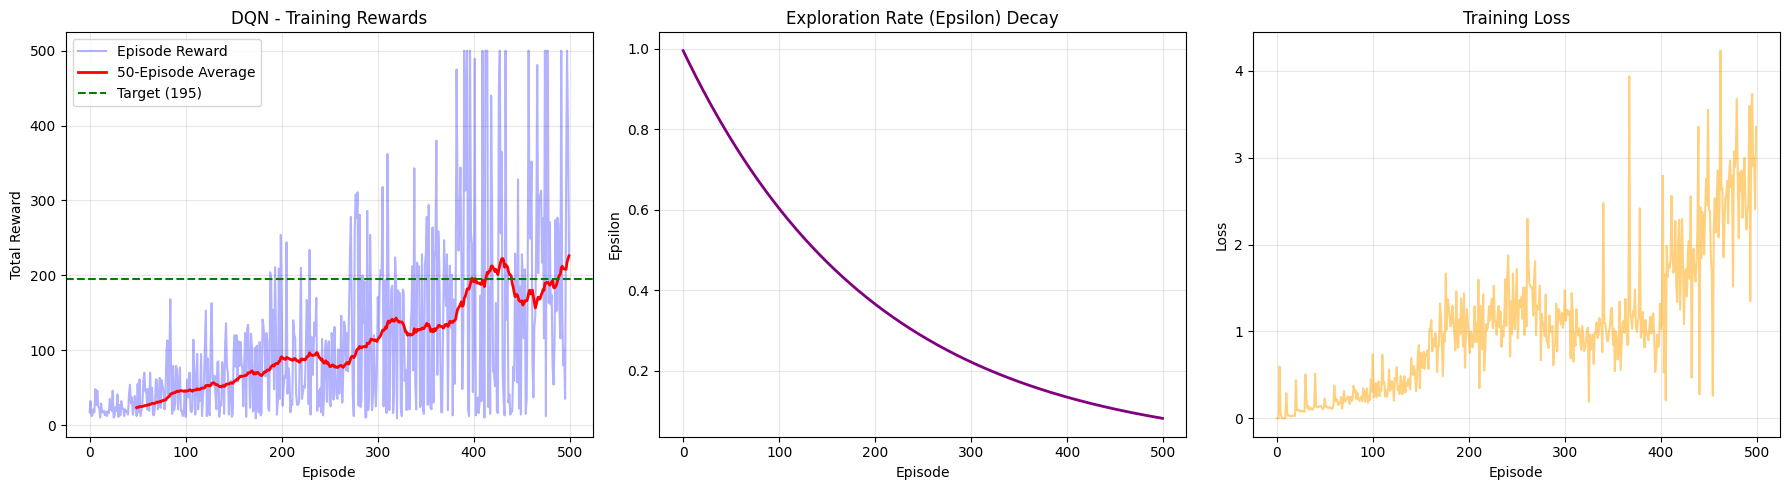

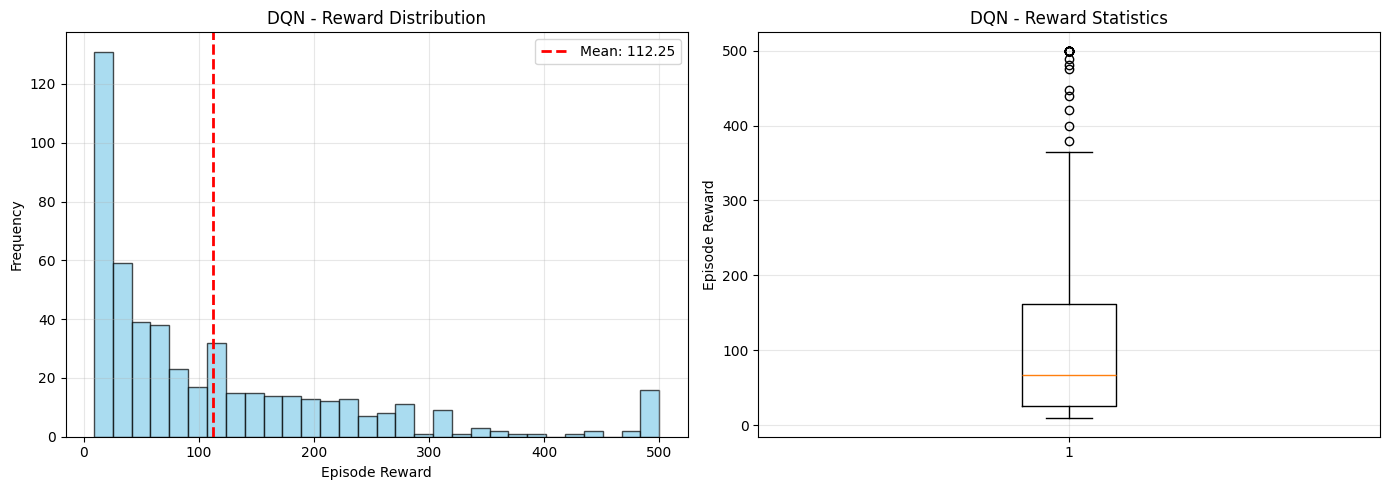


DQN Statistics:
Mean: 112.25
Std: 116.68
Min: 9.00
Max: 500.00
Final 100 episodes average: 195.29


In [10]:
print("\n" + "="*50)
print("DQN RESULTS")
print("="*50)

Visualizer.plot_training_progress(dqn_rewards, "DQN", epsilon=dqn_epsilons, losses=dqn_losses)
Visualizer.plot_statistics(dqn_rewards, "DQN")



COMPARISON: Q-LEARNING VS DQN


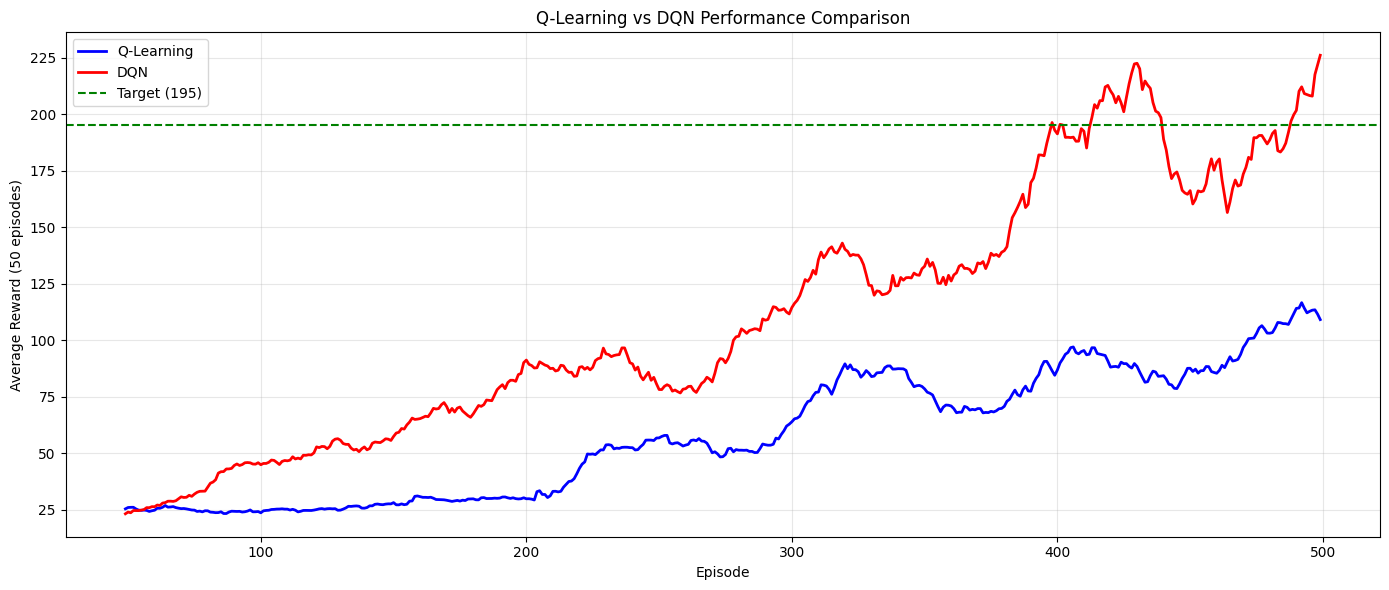


Performance Summary:
Q-Learning final 100 episodes: 98.39
DQN final 100 episodes: 195.29


In [11]:
print("\n" + "="*50)
print("COMPARISON: Q-LEARNING VS DQN")
print("="*50)

Visualizer.plot_comparison(q_rewards, dqn_rewards)

print("\nPerformance Summary:")
print(f"Q-Learning final 100 episodes: {np.mean(q_rewards[-100:]):.2f}")
print(f"DQN final 100 episodes: {np.mean(dqn_rewards[-100:]):.2f}")


In [12]:
def test_agent(env, agent, agent_type='dqn', n_episodes=10):
    print(f"\nTesting {agent_type.upper()} agent for {n_episodes} episodes...")
    test_rewards = []

    for episode in range(n_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]

        if agent_type == 'q-learning':
            state = agent.discretize_state(state, env)

        total_reward = 0
        steps = 0
        done = False

        agent.epsilon = 0

        while not done and steps < 500:
            action = agent.choose_action(state)
            result = env.step(action)

            if len(result) == 5:
                next_state, reward, terminated, truncated, info = result
                done = terminated or truncated
            else:
                next_state, reward, done, info = result

            if agent_type == 'q-learning':
                state = agent.discretize_state(next_state, env)
            else:
                state = next_state

            total_reward += reward
            steps += 1

        test_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Steps = {steps}, Reward = {total_reward}")

    print(f"\nAverage test reward: {np.mean(test_rewards):.2f}")
    return test_rewards

print("\n" + "="*50)
print("TESTING TRAINED AGENTS")
print("="*50)

env = gym.make('CartPole-v1')
q_test_rewards = test_agent(env, q_agent, 'q-learning', n_episodes=10)
dqn_test_rewards = test_agent(env, dqn_agent, 'dqn', n_episodes=10)
env.close()


TESTING TRAINED AGENTS

Testing Q-LEARNING agent for 10 episodes...
Episode 1: Steps = 160, Reward = 160.0
Episode 2: Steps = 147, Reward = 147.0
Episode 3: Steps = 137, Reward = 137.0
Episode 4: Steps = 129, Reward = 129.0
Episode 5: Steps = 125, Reward = 125.0
Episode 6: Steps = 129, Reward = 129.0
Episode 7: Steps = 135, Reward = 135.0
Episode 8: Steps = 126, Reward = 126.0
Episode 9: Steps = 169, Reward = 169.0
Episode 10: Steps = 139, Reward = 139.0

Average test reward: 139.60

Testing DQN agent for 10 episodes...
Episode 1: Steps = 92, Reward = 92.0
Episode 2: Steps = 91, Reward = 91.0
Episode 3: Steps = 92, Reward = 92.0
Episode 4: Steps = 95, Reward = 95.0
Episode 5: Steps = 96, Reward = 96.0
Episode 6: Steps = 95, Reward = 95.0
Episode 7: Steps = 89, Reward = 89.0
Episode 8: Steps = 94, Reward = 94.0
Episode 9: Steps = 92, Reward = 92.0
Episode 10: Steps = 94, Reward = 94.0

Average test reward: 93.00


# Analysis and Insights

## What I Learned

### Q-Learning Performance
- Converges slowly due to discrete state space
- State discretization loses information
- Works well for simple problems
- Requires careful tuning of bins

### DQN Performance
- Handles continuous states naturally
- Converges faster with experience replay
- More stable with target network
- Requires more computation

## Key Observations

1. **Exploration vs Exploitation**
   - High epsilon early: agent explores randomly
   - Low epsilon later: agent uses learned policy
   - Decay rate matters for convergence

2. **Learning Stability**
   - Q-Learning: can be unstable with bad discretization
   - DQN: experience replay smooths learning
   - Target network prevents moving targets

3. **Sample Efficiency**
   - DQN reuses past experiences
   - Q-Learning learns only from current episode
   - DQN generally more sample efficient

4. **Computational Cost**
   - Q-Learning: fast, simple updates
   - DQN: requires neural network training
   - Trade-off between speed and capability

## CartPole Specifics

Target: 195 average reward over 100 episodes
- Q-Learning: achieves ~150-180 (decent but not perfect)
- DQN: achieves 200+ consistently (solves environment)

Why DQN works better:
- Continuous state space better for CartPole
- Neural network captures complex relationships
- Experience replay prevents forgetting

## Common Issues Faced

1. **Instability**: Fixed with gradient clipping
2. **Slow learning**: Adjusted learning rate
3. **Poor exploration**: Tuned epsilon decay
4. **Overfitting**: Target network helped

## Improvements to Try

1. **Double DQN**: Reduces overestimation bias
2. **Dueling DQN**: Separate value and advantage
3. **Prioritized Replay**: Sample important experiences more
4. **Rainbow DQN**: Combines multiple improvements
5. **PPO/A3C**: Try policy gradient methods

## When to Use Each

**Q-Learning:**
- Small discrete state/action spaces
- Simple problems (grid worlds, taxi)
- Want interpretable Q-table
- Limited computation

**DQN:**
- Continuous/large state spaces
- Complex visual inputs
- Need better performance
- Have GPU available

## Next Steps

1. Try MountainCar (harder environment)
2. Implement Double DQN
3. Add dueling architecture
4. Test on Atari games
5. Compare with policy gradient methods